In [239]:
import os

import numpy as np
import pandas as pd
import medspacy
import spacy
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Span

In [2]:
from Reader import Reader

In [588]:
DATA_DIR_RAW = '/Users/chenkx/Desktop/TBIC-not_synced/Negation/data/2010_relations_challenge'
DATA_DIR = r'/Users/chenkx/Box Sync/NLP group/2010 i2b2 challenge - rel'
MAP_DIR = "/Users/chenkx/Desktop/TBIC-not_synced/Negation/notebooks/2010Corpus/section_mapping_v4_all.csv"
FILE_SORTER = r"/Users/chenkx/Box Sync/NLP group/2019 n2c2 Challenge/Track 3 (normalization)/Test/test_file_list.txt"

In [6]:
filenames = [i[:-4] for i in os.listdir(os.path.join(\
    DATA_DIR, "train", "txt")) \
     if i.endswith(".txt")] + [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "test", "txt")) if i.endswith(".txt")]

In [589]:
with open(FILE_SORTER, 'r') as f:
    files2019 = f.read().split('\n')
files2019 = [i for i in files2019 if i != ""]

In [515]:
df = pd.read_csv("explore_i2b2-2010-v5.0-problem_concepts.csv")

In [516]:
df[["filename", "id2"]] = df.id.str.split("::", expand=True)

In [517]:
df

,id,b,e,t,a,c,s,filename,id2
0,284487129::T1,180,215,problem,present,insulin dependent diabetes mellitus,Problems,284487129,T1
1,284487129::T2,236,266,problem,present,anterior myocardial infarction,Problems,284487129,T2
2,284487129::T3,281,296,problem,present,pulmonary edema,Problems,284487129,T3
3,284487129::T4,300,320,problem,present,hypercholesterolemia,Problems,284487129,T4
4,284487129::T5,391,427,problem,present,prior anterior myocardial infarction,Chief complaint,284487129,T5
...,...,...,...,...,...,...,...,...,...
28345,0354::T20,1031,1064,problem,present,a massive subarachnoid hemorrhage,Medications,0354,T20
28346,0354::T21,1070,1104,problem,present,bleeding in the subarachnoid space,Medications,0354,T21
28347,0354::T22,1152,1177,problem,present,significant hydrocephalus,Medications,0354,T22
28348,0354::T24,1218,1235,problem,present,her hydrocephalus,Medications,0354,T24


In [23]:
Span.set_extension("context_gold", default=None)
Span.set_extension("section_gold", default=None)
Span.set_extension("id", default=None)

ValueError: [E090] Extension 'context_gold' already exists on Span. To overwrite the existing extension, set `force=True` on `Span.set_extension`.

In [24]:
# not using 'en_info_3700_i2b2_2012'
nlp = medspacy.load(medspacy_enable=["medspacy_pyrush", "medspacy_context"])

In [25]:
print(nlp.pipe_names)

['medspacy_pyrush', 'medspacy_context']


In [26]:
context = nlp.get_pipe("medspacy_context")
context

In [110]:
context.rules

[ConTextRule(literal='absence of', category='NEGATED_EXISTENCE', pattern=None, direction='FORWARD'),
 ConTextRule(literal='adequate to rule out', category='NEGATED_EXISTENCE', pattern=[{'LOWER': {'IN': ['adequate', 'sufficient']}}, {'LOWER': 'to'}, {'LOWER': 'rule'}, {'LOWER': {'IN': ['him', 'her', 'them', 'patient', 'pt']}, 'OP': '?'}, {'LOWER': 'out'}, {'LOWER': {'IN': ['against', 'for']}, 'OP': '?'}], direction='FORWARD'),
 ConTextRule(literal='adequate to rule the patient out', category='NEGATED_EXISTENCE', pattern=[{'LOWER': {'IN': ['adequate', 'sufficient']}}, {'LOWER': 'to'}, {'LOWER': 'rule'}, {'LOWER': 'the'}, {'LOWER': {'IN': ['patient', 'pt']}}, {'LOWER': 'out'}, {'LOWER': {'IN': ['against', 'for']}, 'OP': '?'}], direction='FORWARD'),
 ConTextRule(literal='any other', category='NEGATED_EXISTENCE', pattern=None, direction='FORWARD'),
 ConTextRule(literal='apart from', category='NEGATED_EXISTENCE', pattern=[{'LOWER': 'apart'}, {'LOWER': {'IN': ['for', 'from']}}], direction='TE

In [16]:
context.context_attributes_mapping

{'NEGATED_EXISTENCE': {'is_negated': True},
 'POSSIBLE_EXISTENCE': {'is_uncertain': True},
 'HISTORICAL': {'is_historical': True},
 'HYPOTHETICAL': {'is_hypothetical': True},
 'FAMILY': {'is_family': True}}

In [518]:
with open('context_outputs.csv', 'w') as f:
    f.write('id,b,e,t,c,a,s,is_family,is_historical,is_hypothetical,is_negated,is_uncertain,prediction')

In [519]:
for file in filenames:
    try:
        reader = Reader(os.path.join(DATA_DIR, 'train'), file)
    except FileNotFoundError:
        reader = Reader(os.path.join(DATA_DIR, 'test'), file)
    doc = nlp(reader.txt)
    subdf = df[df['filename']==file]
    ents = []
    for start, end, label, assertion, section, idname in subdf[['b','e', 't', 'a', 's', 'id']].values:
        span = doc.char_span(start, end, label=label)
        if not span:
            print(f"WARNING: {file} {start}-{end}")
            continue
        span._.section_gold = section
        span._.context_gold = assertion
        span._.id = idname
        ents.append(span)
    doc.ents = ents
    context(doc)
#     print(f'{file}: {doc._.context_graph}')
    for en in doc.ents:
        pred = [i for i, x in enumerate([en._.is_family,en._.is_historical,en._.is_hypothetical,en._.is_negated,en._.is_uncertain]) if x]
        if not pred:
            context_pred = 'present'
        elif len(pred) >1:
            context_pred = 'multiple'
        else:
            context_pred = ['associated_with_someone_else', 'absent', 'hypothetical', 'absent', 'possible'][pred[0]] # historical is conditional??
        with open('context_outputs.csv', 'a') as f:
            f.write(f'\n{en._.id},{en.start_char},{en.end_char},?,?,{en._.context_gold},{en._.section_gold},{en._.is_family},{en._.is_historical},{en._.is_hypothetical},{en._.is_negated},{en._.is_uncertain},{context_pred}')

## Evaluation

In [536]:
outputs = pd.read_csv("context_outputs.csv") 

In [559]:
# consolidate Assessment, Plan, Assessment/Plan. and Investigations/Results, Radiology, Laboratory tests. 
# manually correct 0065.txt section = "Advance directive/Code". change them to diagnoses 
outputs.s[(outputs.s=='Assessment') | (outputs.s=='Plan')] = "Assessment/Plan"
outputs.s[(outputs.s=='Radiology') | (outputs.s=='Laboratory tests')] = "Investigations/Results"
outputs.s[(outputs.s=='Procedures')] = "Procedures/Surgery"
outputs.s[(outputs.s=='0')] = "Investigations/Results"
outputs.s[outputs.s=='Advance directive/Code'] = 'Diagnoses'

In [560]:
outputs

,id,b,e,t,c,a,s,is_family,is_historical,is_hypothetical,is_negated,is_uncertain,prediction
0,284487129::T1,180,215,?,?,present,Problems,False,False,False,False,False,present
1,284487129::T2,236,266,?,?,present,Problems,False,True,False,False,False,absent
2,284487129::T3,281,296,?,?,present,Problems,False,False,False,False,False,present
3,284487129::T4,300,320,?,?,present,Problems,False,False,False,False,False,present
4,284487129::T5,391,427,?,?,present,Chief complaint,False,True,False,False,False,absent
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28341,0354::T20,1031,1064,?,?,present,Medications,False,True,False,False,False,absent
28342,0354::T21,1070,1104,?,?,present,Medications,False,True,False,False,False,absent
28343,0354::T22,1152,1177,?,?,present,Medications,False,False,False,False,False,present
28344,0354::T24,1218,1235,?,?,present,Medications,False,False,False,False,False,present


In [573]:
outputs[["filename", "item"]] = outputs.id.str.split('::', expand=True)

,id,b,e,t,c,a,s,is_family,is_historical,is_hypothetical,is_negated,is_uncertain,prediction,filename,item
0,284487129::T1,180,215,?,?,present,Problems,False,False,False,False,False,present,284487129,T1
1,284487129::T2,236,266,?,?,present,Problems,False,True,False,False,False,absent,284487129,T2
2,284487129::T3,281,296,?,?,present,Problems,False,False,False,False,False,present,284487129,T3
3,284487129::T4,300,320,?,?,present,Problems,False,False,False,False,False,present,284487129,T4
4,284487129::T5,391,427,?,?,present,Chief complaint,False,True,False,False,False,absent,284487129,T5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28341,0354::T20,1031,1064,?,?,present,Medications,False,True,False,False,False,absent,0354,T20
28342,0354::T21,1070,1104,?,?,present,Medications,False,True,False,False,False,absent,0354,T21
28343,0354::T22,1152,1177,?,?,present,Medications,False,False,False,False,False,present,0354,T22
28344,0354::T24,1218,1235,?,?,present,Medications,False,False,False,False,False,present,0354,T24


In [600]:
outputs = outputs[outputs.filename.isin(files2019)]

In [599]:
for file in outputs2.filename.unique():
#     if len(outputs2[outputs2.filename==file].s.unique())  == 2:
#         if outputs[outputs.filename==file].s.unique() not in ["Unknown/Unclassified", "Patient information/Demographics"]:
    print(f'file: {file}, section: {outputs2[outputs2.filename==file].s.unique()}, len={len(outputs2[outputs2.filename==file].s)}')
#     print(outputs2[outputs2.filename==file])

file: 134300717, section: ['Unknown/Unclassified' 'Diagnoses' 'Present illness' 'Allergies'
 'Physical examination/Status' 'Hospital course'], len=32
file: 337702516_WGH, section: ['Patient information/Demographics' 'Present illness' 'Allergies'
 'Physical examination/Status' 'Hospital course' 'Medications'], len=44
file: 351853846_WGH, section: ['Unknown/Unclassified' 'Diagnoses' 'Present illness' 'Past history'
 'Allergies' 'Physical examination/Status' 'Investigations/Results'
 'Hospital course'], len=53
file: 274230067_EH, section: ['Diagnoses' 'Present illness' 'Past history' 'Allergies'
 'Physical examination/Status' 'Hospital course'], len=29
file: 523704694, section: ['Diagnoses' 'Present illness' 'Past history' 'Medications' 'Allergies'
 'Physical examination/Status' 'Investigations/Results' 'Hospital course'
 'Follow-up/Instructions'], len=72
file: 767751445_ELMVH, section: ['Unknown/Unclassified' 'Allergies' 'Diagnoses' 'Procedures/Surgery'
 'Hospital course' 'Investigations

In [601]:
section_cnt = outputs.groupby(['s'])[['c']].agg('count').reset_index()

In [602]:
outputs.a.unique()

array(['present', 'absent', 'possible', 'associated_with_someone_else',
       'hypothetical', 'conditional'], dtype=object)

In [603]:
asst_map = {"present":"prediction", 
            'absent':'is_negated', 
            'associated_with_someone_else':'is_family', 
            'hypothetical':'is_hypothetical',
            'possible':'is_uncertain'
           }

In [677]:
# micro F1, recall, precision 
for ast in assertion_types:
    ref = outputs.a == ast
    if ast == 'present':
        pred = outputs.prediction == 'present'
    else:
        pred = outputs[asst_map[ast]]
    print('\t'+ast)
#     res['Recall'].append(round(metrics.recall_score(ref, pred),3))
#     res['Precision'].append(round(metrics.precision_score(ref, pred),3))
#     res['F'].append(round(metrics.f1_score(ref, pred), 3))

    try:
        print(metrics.classification_report(ref, pred, target_names=['Others(0)', ast+"(1)"]))
    except ValueError:
        print(f'ref: {len(set(ref))}, pred: {len(set(pred))}')


	present
              precision    recall  f1-score   support

   Others(0)       0.52      0.81      0.63       802
  present(1)       0.88      0.65      0.74      1683

    accuracy                           0.70      2485
   macro avg       0.70      0.73      0.69      2485
weighted avg       0.76      0.70      0.71      2485

	absent
              precision    recall  f1-score   support

   Others(0)       0.96      0.81      0.88      1870
   absent(1)       0.61      0.90      0.73       615

    accuracy                           0.83      2485
   macro avg       0.78      0.86      0.80      2485
weighted avg       0.87      0.83      0.84      2485

	associated_with_someone_else
                                 precision    recall  f1-score   support

                      Others(0)       1.00      0.96      0.98      2470
associated_with_someone_else(1)       0.15      1.00      0.26        15

                       accuracy                           0.96      2485
     

In [625]:
res={'Section':[], 
     'Assertion':[], 
     'Count':[],
     'Recall':[], 
     'Precision':[], 
     'F':[]}

for sec in outputs.s.unique():
    tmpdf = outputs[outputs.s==sec]
#     print(sec)
    assertion_types = asst_map.keys()
    res['Section'].extend([sec] * len(assertion_types))
    res['Assertion'].extend(assertion_types)
    for ast in assertion_types:
        ref = tmpdf.a == ast
        res['Count'].append(sum(ref))
        if ast == 'present':
            pred = tmpdf.prediction == 'present'
        else:
            pred = tmpdf[asst_map[ast]]
#         print('\t'+ast)
        res['Recall'].append(round(metrics.recall_score(ref, pred),3))
        res['Precision'].append(round(metrics.precision_score(ref, pred),3))
        res['F'].append(round(metrics.f1_score(ref, pred), 3))
    
#         try:
#             metrics.classification_report(ref, pred, target_names=['Others(0)', ast+"(1)"])
#         except ValueError:
#             print(f'ref: {len(set(ref))}, pred: {len(set(pred))}')

res = pd.DataFrame(res)
res

,Section,Assertion,Count,Recall,Precision,F
0,Unknown/Unclassified,present,42,1.0,1.0,1.0
1,Unknown/Unclassified,absent,0,0.0,0.0,0.0
2,Unknown/Unclassified,associated_with_someone_else,0,0.0,0.0,0.0
3,Unknown/Unclassified,hypothetical,0,0.0,0.0,0.0
4,Unknown/Unclassified,possible,0,0.0,0.0,0.0
...,...,...,...,...,...,...
100,Complications,present,2,1.0,1.0,1.0
101,Complications,absent,0,0.0,0.0,0.0
102,Complications,associated_with_someone_else,0,0.0,0.0,0.0
103,Complications,hypothetical,0,0.0,0.0,0.0


In [626]:
# res = res[res.Count > 0].reset_index(drop=True)
res = res.merge(section_cnt, left_on=['Section'], right_on=['s'])
res.rename(columns={'c':'Total_count'}, inplace=True)
res.drop(columns=['s'], inplace=True)
res['percentage'] = round(res.Count/res.Total_count, 3)
print(f'Unclassified={res[res.Section=="Unknown/Unclassified"].Count.sum()}')
res = res[res.Section!="Unknown/Unclassified"]
res

Unclassified=42


,Section,Assertion,Count,Recall,Precision,F,Total_count,percentage
5,Diagnoses,present,171,0.854,1.0,0.921,172,0.994
6,Diagnoses,absent,0,0.000,0.0,0.000,172,0.000
7,Diagnoses,associated_with_someone_else,0,0.000,0.0,0.000,172,0.000
8,Diagnoses,hypothetical,0,0.000,0.0,0.000,172,0.000
9,Diagnoses,possible,1,1.000,0.2,0.333,172,0.006
...,...,...,...,...,...,...,...,...
100,Complications,present,2,1.000,1.0,1.000,2,1.000
101,Complications,absent,0,0.000,0.0,0.000,2,0.000
102,Complications,associated_with_someone_else,0,0.000,0.0,0.000,2,0.000
103,Complications,hypothetical,0,0.000,0.0,0.000,2,0.000


In [627]:
res.Section.unique()

array(['Diagnoses', 'Present illness', 'Allergies',
       'Physical examination/Status', 'Hospital course',
       'Patient information/Demographics', 'Medications', 'Past history',
       'Investigations/Results', 'Follow-up/Instructions',
       'Procedures/Surgery', 'Review of systems', 'Family history',
       'Chief complaint', 'Reasons/Indications', 'Social history',
       'Problems', 'Addendum', 'Assessment/Plan', 'Complications'],
      dtype=object)

In [665]:
plotdf = res[res.percentage == res.groupby("Section").percentage.transform(max)].sort_values(['Total_count', 'Section', 'Assertion'], ascending=[False, True, True]).reset_index(drop=True)
plotdf

,Section,Assertion,Count,Recall,Precision,F,Total_count,percentage
0,Hospital course,present,423,0.759,0.845,0.800,652,0.649
1,Present illness,present,441,0.667,0.955,0.785,554,0.796
2,Physical examination/Status,absent,263,0.905,0.692,0.784,504,0.522
3,Past history,present,168,0.304,0.927,0.457,191,0.880
4,Diagnoses,present,171,0.854,1.000,0.921,172,0.994
5,Investigations/Results,present,100,0.570,0.919,0.704,142,0.704
6,Review of systems,absent,25,1.000,0.658,0.794,44,0.568
7,Medications,hypothetical,26,0.077,1.000,0.143,37,0.703
8,Allergies,absent,16,0.812,0.867,0.839,29,0.552
9,Reasons/Indications,present,16,0.250,0.500,0.333,25,0.640


In [649]:
# pd.pivot(res, index='Section', columns='Assertion', values=['Count', 'Recall', 'Precision', 'F', 'percentage', 'Total_count']).sort_values(by=['Section'], key=lambda x: x.map(custom_dict)).to_csv('Context-outputs-by-section-limited.csv')

In [668]:
# set plotting config 
sns.set(rc={"figure.figsize":(32, 10)}) #width=32, height=16
sns.set(font_scale=2) #increase font size of all elements

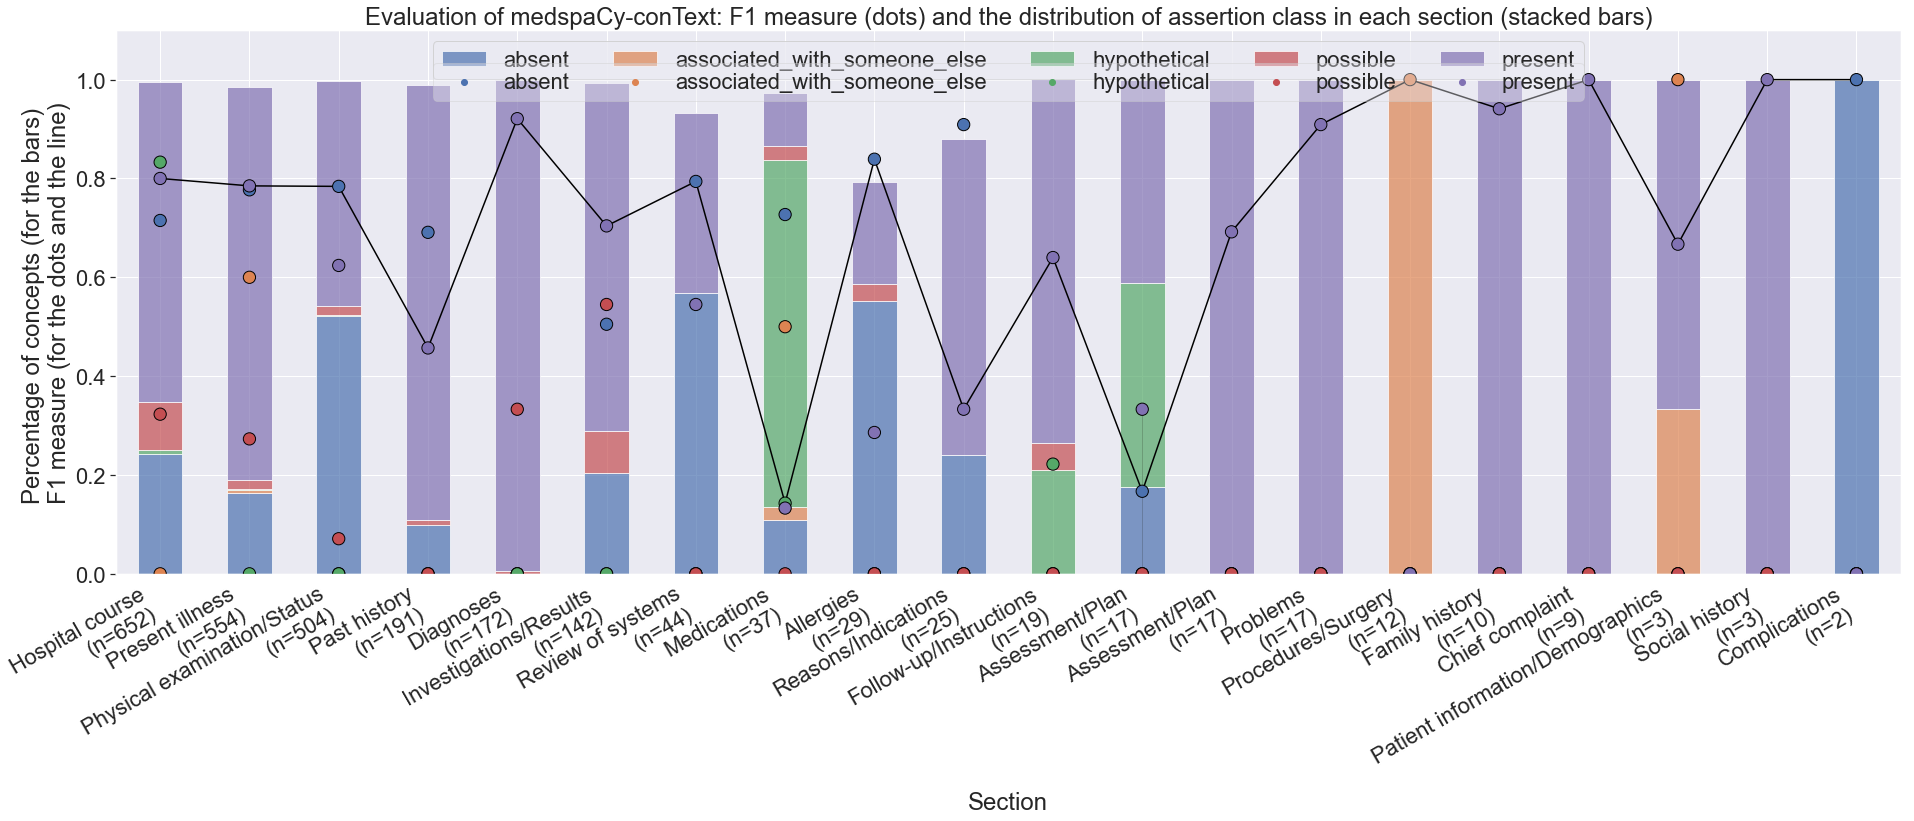

In [674]:
# plotdata = pd.melt(res, id_vars=['Semantics', 'counts'], value_vars=[x[0] for x in acc], var_name='team', value_name='accuracy')
## stacked bars of distribution
custom_dict = {sec:i for i, sec in enumerate(plotdf.Section)}
ax = pd.pivot(res[['Section', 'Assertion', 'percentage']], index=['Section'], columns='Assertion', values='percentage').sort_values(by=['Section'], key=lambda x: x.map(custom_dict)).plot(kind='bar', stacked=True, alpha=0.7)

## common settings
plt.legend(loc='upper center', ncol=5) # bbox_to_anchor=(0.5, 1.05)
plt.ylim(0,1.1)
plt.title('Evaluation of medspaCy-conText: F1 measure (dots) and the distribution of assertion class in each section (stacked bars)')
plt.ylabel('Percentage of concepts (for the bars) \nF1 measure (for the dots and the line)')

## black line of F1 (dominant class)
ax2 = plt.twinx()
sns.lineplot(x= 'Section', y='F', data=plotdf, color='black', ax=ax2)
plt.ylim(0,1.1)
ax2.get_yaxis().set_visible(False)

## scatter plots of F1
ax3 = ax2.twinx()
sns.scatterplot(x='Section', y='F', hue='Assertion', data=res.replace('f', {0.0:np.nan}).sort_values(['Total_count', 'Section', 'Assertion'], ascending=[False, True, True])[['Section', 'Assertion', 'F']], edgecolor="black", s=150, ax=ax3)
plt.ylim(0,1.1)
ax3.legend(loc='upper center', ncol=5,bbox_to_anchor=(0.5, 0.96),framealpha=0.4)
ax3.get_yaxis().set_visible(False)

ax.set_xticklabels([f'{row.Section}\n(n={row.Total_count})' for i, row in plotdf.iterrows()], ha='right', rotation=30)


plt.savefig("CONTEXT-f1-by-section-limitedData.png", bbox_inches='tight')
plt.show()

f1scores = []
for i in outputs.s.unique():
    goldtype = outputs[outputs.s==i].a.mode()[0]
    
    gold2 = outputs[outputs.s==i].a == goldtype
    pred2 = outputs[outputs.s==i].prediction == goldtype
    
    print(i)
    try:
        print(metrics.classification_report(gold2, pred2, target_names=['Others(0)', goldtype+"(1)"]))
        f1scores.append((i, outputs.s.value_counts()[i], goldtype, metrics.f1_score(gold2, pred2)))
    except Exception:
        print(i, goldtype)
        pass
f1scores.sort(key=lambda x: -x[1])
f1scores

### For binary contexual types (negated or asserted)

In [34]:
gold = outputs.a == "present"
pred = outputs.prediction == "present"

In [35]:
metrics.f1_score(gold, pred)

0.7651390728476822

In [36]:
print(metrics.classification_report(gold, pred, target_names=['Negated', 'Asserted']))

              precision    recall  f1-score   support

     Negated       0.52      0.76      0.62      9440
    Asserted       0.87      0.69      0.77     21073

    accuracy                           0.71     30513
   macro avg       0.69      0.72      0.69     30513
weighted avg       0.76      0.71      0.72     30513



In [310]:
f1scores = {}
for i in outputs.s.unique():
    gold2 = gold[outputs.s == i]
    pred2 = pred[outputs.s == i]
    print(i)
    try:
        print(metrics.classification_report(gold2, pred2, target_names=['Negated', 'Asserted']))
        f1scores[i] = metrics.f1_score(gold2, pred2)
    except Exception:
        f1scores[i] = None
        pass

Problems
              precision    recall  f1-score   support

     Negated       0.48      0.61      0.54        36
    Asserted       0.89      0.83      0.86       141

    accuracy                           0.79       177
   macro avg       0.69      0.72      0.70       177
weighted avg       0.81      0.79      0.79       177

Chief complaint
              precision    recall  f1-score   support

     Negated       0.46      0.72      0.57        18
    Asserted       0.94      0.85      0.89        98

    accuracy                           0.83       116
   macro avg       0.70      0.78      0.73       116
weighted avg       0.87      0.83      0.84       116

Present illness
              precision    recall  f1-score   support

     Negated       0.41      0.85      0.55       354
    Asserted       0.92      0.59      0.72      1060

    accuracy                           0.65      1414
   macro avg       0.67      0.72      0.63      1414
weighted avg       0.79      0.65

In [309]:
print("\n".join([str(round(i,3)) for i in f1scores.values()]))

0.86
0.892
0.717
0.549
0.835
0.0
0.725
0.739
0.772
0.64
0.488
0.786
0.729
0.92
0.802
0.857
0.719
0.827
0.667
0.865
0.694
0.718
0.6
0.827
0.571
0.81
0.824
0.875
0
0.0


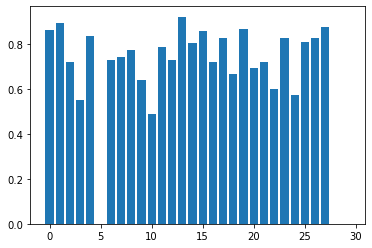

In [303]:
plt.bar(range(len(f1scores)), f1scores.values(), tick_label=f1scores.keys())
plt.show()

In [ ]:
# 

Discarded

In [193]:
doc = nlp(reader.txt)

In [194]:
subdf = df[df['filename']==file]
subdf.head()

,id,b,e,t,a,c,s,filename,id2
0,284487129::T1,180,215,problem,present,insulin dependent diabetes mellitus,Problems,284487129,T1
1,284487129::T2,236,266,problem,present,anterior myocardial infarction,Problems,284487129,T2
2,284487129::T3,281,296,problem,present,pulmonary edema,Problems,284487129,T3
3,284487129::T4,300,320,problem,present,hypercholesterolemia,Problems,284487129,T4
4,284487129::T5,391,427,problem,present,prior anterior myocardial infarction,Chief complaint,284487129,T5


In [211]:
ents = []
for start, end, label, assertion, section, idname in subdf[['b','e', 't', 'a', 's', 'id']].values:
    span = doc.char_span(start, end, label=label)
    span._.section_gold = section
    span._.context_gold = assertion
    span._.id = idname
    ents.append(span)
doc.ents = ents

In [122]:
# Visualizae entities
# from medspacy.visualization import visualize_ent
# visualize_ent(doc)

In [212]:
context(doc)

284487129
CTMC
42669672
466333
01/16/1996 12:00:00 AM
Discharge Summary
Signed
DIS
Admission Date :
01/16/1996
Report Status :
Signed
Discharge Date :
01/20/1996
PROBLEM LIST :
1. INSULIN DEPENDENT DIABETES MELLITUS
2. PRIOR HISTORY OF ANTERIOR MYOCARDIAL INFARCTION
3. EPISODE OF PULMONARY EDEMA
4. HYPERCHOLESTEROLEMIA
CHIEF COMPLAINT :
The patient is a 40 year old male with a history of prior anterior myocardial infarction and insulin dependent diabetes mellitus who was transferred from an outside hospital after an episode of acute shortness of breath and pulmonary edema .
HISTORY OF PRESENT ILLNESS :
The patient has a history four years ago of being admitted to the Etearal Etsystems/ Hospital after suffering an acute anterior myocardial infarction .
The course had multiple complications requiring pressors .
He had a cardiac catheterization performed which revealed a three vessel coronary artery disease with an occluded RCA , 70%-80% proximal LAD , and a high grade left circumflex les

In [245]:
print(doc._.context_graph)

<ConTextGraph> with 54 targets and 33 modifiers


In [243]:
for en in doc.ents:
    pred = [i for i, x in enumerate([en._.is_family,en._.is_historical,en._.is_hypothetical,en._.is_negated,en._.is_uncertain]) if x]
    if not pred:
        context_pred = 'present'
    elif len(pred) >1:
        context_pred = 'multiple'
    else:
        context_pred = ['associated_with_someone_else', 'absent', 'hypothetical', 'absent', 'possible'][pred[0]] # historical is conditional??
    print(f'\n{en._.id},{en.start_char},{en.end_char},?,{en.text},{en._.context_gold},{en._.section_gold},{en._.is_family},{en._.is_historical},{en._.is_hypothetical},{en._.is_negated},{en._.is_uncertain}, {context_pred}')